# Yield forecasting using Planetary Variables
Planetary Variables offer deep insights into the state of the soil and vegetation. We can use these insights to forecast crop yield. Here we show an example on how to make a crop yield forecast using multiple Planetary Variables. We are going to predict the yield of hay in the US state of North Dakota using three Planetary Variables: Soil Water Content, Land Surface Temperature, and Vegetation Optical Depth. In this notebook, we show how to make a yield forecast for 2024 using a simple Python algorithm.


### Table of Contents
[Hay yield in North Dakota](#Hay-yield-in-North-Dakota)

[Soil Water Content](#Soil-Water-Content)

[Land Surface Temperature](#Land-Surface-Temperature)

[Vegetation Optical Depth](#Vegetation-Optical-Depth)

[Statistics](#Statistics)

[Forecasting yield using SWC, LST, and VOD](#Forecasting-yield-using-SWC,-LST,-and-VOD)

[Conclusions](#Conclusions)

[References](#References)


## Hay yield in North Dakota
Agriculture is an important economic sector in the US state of North Dakota, and about 90 percent of its land area is used for farming. 
From our Planet Satellites, North Dakota can clearly be classified as an agricultural state:

![North Dakota (Planet Basemaps July-October 2024)](fig/ND.jpeg)

Most of the state is indeed covered by farm- and grassland, and we only see a few densely-vegetated and urban areas. 

Hay, used as forage, is one of the most-produced crops. The US Department of Agriculture (USDA) [estimated][1] the value of the produced hay in North Dakota to be over 475 million dollars, which makes it the fifth crop in the state, after soybeans, corn, wheat, and canola. Hay typically grows on non-irrigated fields. Therefore, hay yield is susceptible to droughts and heatwaves. USDA keeps track of the amount of harvested hay. By dividing this amount by the acreage of the hay fields, we get the yield. We have obtained the annual yield data for North Dakota from USDA. 

First, we import some Python packages for our analysis and then we read the downloaded CSV file and plot a time series of annual yield. 

[1]: https://www.nass.usda.gov/Quick_Stats/Ag_Overview/stateOverview.php?state=NORTH%20DAKOTA

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
import numpy as np
from scipy.stats import spearmanr, pearsonr
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
try:
    from planet_style import set_style
    set_style()
    cmap_RdBu= mpl.colormaps.get_cmap('planet.pv.lst_diverging')
    cmap_RdBu.set_bad(color='#d2d2d2')
except ImportError as e:   
    cmap_RdBu= mpl.colormaps.get_cmap('RdBu_r')
    cmap_RdBu.set_bad(color='#d2d2d2')

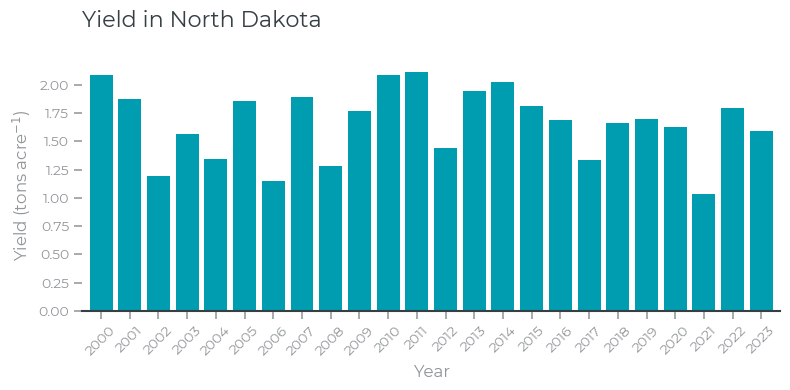

In [2]:
Yield = pd.read_csv(f"csv/Yield_ND.csv",usecols= ['Year','Value'], index_col='Year').sort_index().rename(columns={'Value':"Yield"})
fig, ax = plt.subplots(figsize=(8,4))
ax.set_title("Yield in North Dakota")
Yield.plot.bar(ax=ax, rot=45, legend=False, width=0.8)
ax.set_xlabel('Year')
ax.set_ylabel('Yield (tons acre$^{-1}$)')
fig.tight_layout()

The yield of hay in North Dakota varies a lot from year to year. For example, the yields in 2006 and especially in 2021 were only about half the yields in 2000 and 2011. Can we use Planetary Variables to find out whether changes in soil water content or land surface temperature (or both) during the growing season could explain these variations?

## Soil Water Content
Planet Soil Water Content is a measurement of the amount of water in the upper layer of the soil. Crops need water for growth, but a too moist soil causes crop damage as well. Therefore, accurate soil water content measurements give insight into the soil conditions needed for healthy crow growth.

To determine soil water content, we use satellite microwave radiometers. The amount of water affects the amount of microwave radiation emitted by the soil, as well as its polarization. From the polarization and intensity measured by the radiometer, we compute soil water content. Generally, the most reliable and accurate microwave frequency band to determine SWC is the L-band. The radiometer on board NASA's SMAP satellite measures radiation in this band. However, since it has been launched in 2015, we only have a relatively short record available for our analysis. An alternative is to use the higher-frequency C band. While slightly less accurate, especially over densely forested regions, it has been continuously recorded by the AMSR2 instrument since 2012. As you can see in the image above, North Dakota is mostly covered with grassland and crops, and thus C-band observations can be used here as well. 

Let's read the C-band SWC data and plot alongside hay yield. SWC is expressed as the volume fraction, and has units $m^3$ $m^{-3}$. We have a satellite observation at least every two days. Below, we compute the average SWC over the growing season from May to July. 

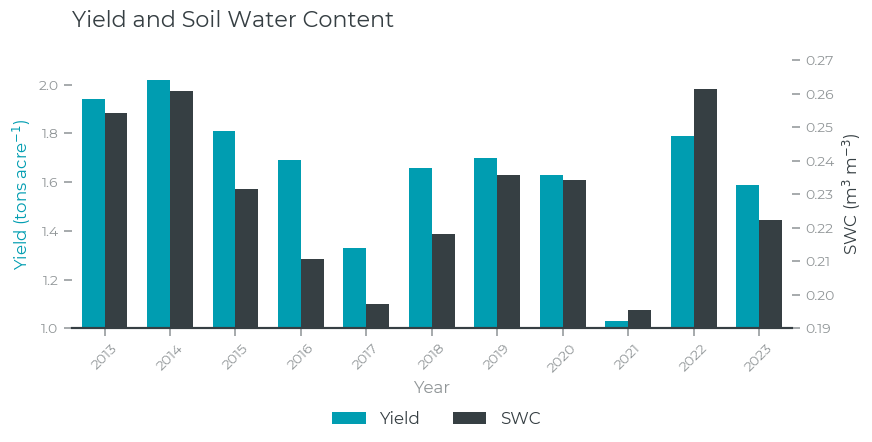

In [3]:
SWC_daily = pd.read_csv(f"csv/SWC_C_ND.csv",skiprows=6,index_col='date',parse_dates=True).rename(columns={'SM-AMSR2-C1-DESC_V5.0_1000':"SWC"})
SWC_daily = SWC_daily[(SWC_daily.index.month >= 5) & (SWC_daily.index.month < 8) & (SWC_daily.index.year>2012)]
SWC_growing_season = SWC_daily.groupby(SWC_daily.index.year).mean()
Yield_SWC = pd.concat([Yield, SWC_growing_season], axis=1, join="inner")

fig, ax1 = plt.subplots(figsize=(8,4))
ax1.set_title("Yield and Soil Water Content")
Yield_SWC.plot.bar(y='Yield',ax=ax1,width=0.35,rot=45,position=1,legend=False)
ax1.set_xlabel('Year')
ax1.set_ylabel('Yield (tons acre$^{-1}$)',color='C0')
ax1.set_ylim([1.0,2.1])
ax2 = ax1.twinx()
Yield_SWC.plot.bar(y='SWC',ax=ax2,width=0.35,rot=45,position=0,color='C1',legend=False)
ax2.set_ylabel('SWC (m$^{3}$ m$^{-3}$)',color='C1')
ax2.set_xlim(np.where(Yield_SWC.index == 2013)[0] - 0.5, np.where(Yield_SWC.index == 2023)[0] + 0.5)
ax2.set_ylim([0.19,0.27])
fig.legend(loc="lower center",ncols=2)
fig.subplots_adjust(left=0.05, bottom=0.28, right=0.95, top=0.95, wspace=0.4, hspace=0.2)

At a first glance, SWC and yield show a lot of similarities! Higher soil water content clearly coincides with high yield. During 2017 and 2021, when the yield was the lowest during the 2013-2023 period, the soil was also very dry. However, SWC alone does not explain all the variations: for example, SWC in 2017 and 2021 show similarly low values, but the yield in 2021 was much lower than 2017. Let's see whether we can use land surface temperature to explain this.

## Land Surface Temperature
Planet Land Surface Temperature is the satellite-measured skin temperature of the Earth surface. Similar to SWC, it has been measured using microwave radiometers, but in a different band: the Ka-band. Let's read and plot the data. 

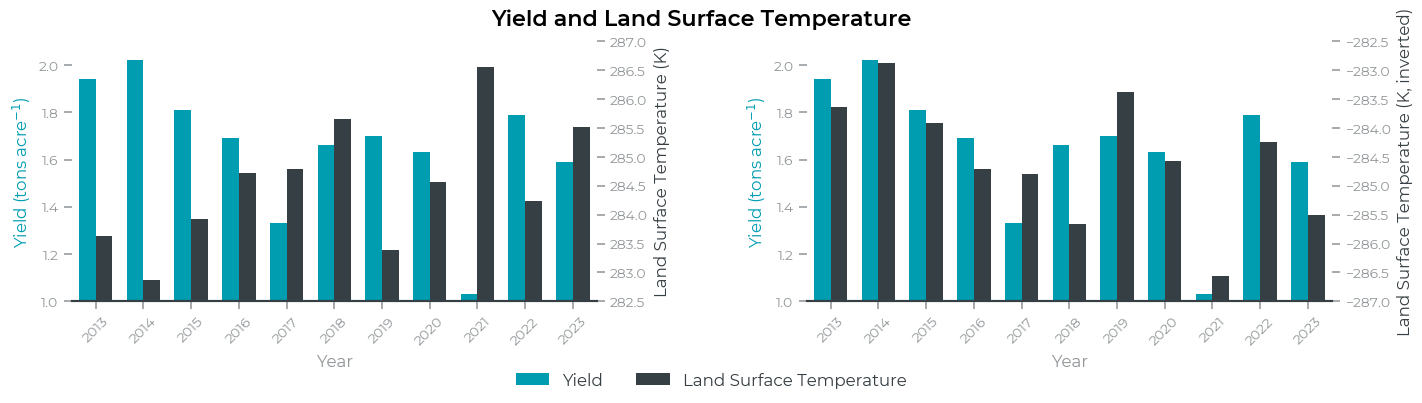

In [4]:
LST_daily = pd.read_csv(f"csv/LST_ND.csv",skiprows=6,index_col='date',parse_dates=True).rename(columns={'LST-AMSR2-DESC_V1.0_1000':"LST"})
LST_daily = LST_daily[(LST_daily.index.month >= 5) & (LST_daily.index.month < 8) & (LST_daily.index.year>2012)]
LST_growing_season = LST_daily.groupby(LST_daily.index.year).mean()
LST_gs_negative=-LST_growing_season.rename(columns={'LST':"LST_neg"})+300
Yield_LST = pd.concat([Yield, LST_growing_season, LST_gs_negative], axis=1, join="inner", )

fig, ax = plt.subplots(1,2,figsize=(14,4))
fig.suptitle("Yield and Land Surface Temperature", fontsize=16)
Yield_LST.plot.bar(y='Yield',ax=ax[0],width=0.35,rot=45,position=1,legend=False, label='Yield')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Yield (tons acre$^{-1}$)',color='C0')
ax[0].set_ylim([1.0,2.1])
ax2 = ax[0].twinx()
Yield_LST.plot.bar(y='LST',ax=ax2,width=0.35,rot=45,position=0,color='C1',legend=False,label='Land Surface Temperature')
ax2.set_ylabel('Land Surface Temperature (K)',color='C1')
ax2.set_xlim(np.where(Yield_SWC.index == 2013)[0] - 0.5, np.where(Yield_SWC.index == 2023)[0] + 0.5)
ax2.set_ylim([282.5,287])

ax[1].set_xlabel('Year')
ax[1].set_ylabel('Yield (tons acre$^{-1}$)',color='C0')
ax[1].set_ylim([1.0,2.1])
Yield_LST.plot.bar(y='Yield',ax=ax[1],width=0.35,rot=45,position=1,legend=False,label="")

ax3 = ax[1].twinx()
Yield_LST.plot.bar(y='LST_neg',ax=ax3,width=0.35,rot=45,position=0,color='C1',legend=False, bottom=-300,label="")
ax3.set_ylabel('SWC (m$^{3}$ m$^{-3}$)',color='C1')
ax3.set_xlim(np.where(Yield_SWC.index == 2013)[0] - 0.5, np.where(Yield_SWC.index == 2023)[0] + 0.5)
ax3.set_ylim([-287,-282.5])
ax3.set_ylabel('Land Surface Temperature (K, inverted)',color='C1')
fig.legend(loc="lower center",ncols=2)
fig.subplots_adjust(left=0.05, bottom=0.25, right=0.95, top=0.9, wspace=0.4, hspace=0.2)

Here, we also find a clear connection, but upside down: lower land surface temperatures during the growing season result in higher yield. When we invert the temperatures (right panel), we can see the high level of agreement. While SWC showed similar low values for 2017 and 2021, LST shows a lower value for 2021 than for 2017. This suggests that the heat, and not just the drought in 2021 might explain the difference between the yield for both years.


## Vegetation Optical Depth
For SWC and LST, we measure the microwave radiation from the surface. However, the vegetation on top of the surface absorbs some of this radiation. The algorithm that we use to compute soil water content from this radiation (LPRM) computes this absorption, which we express as Vegetation Optical Depth (VOD). The higher the VOD, the more radiation is absorbed. 

A high VOD means two things:
- Dense vegetation
- High vegetation water content, which generally means healthier vegetation.

VOD is therefore an indicator of the amount and health of the vegetation. As such, it might be useful for our yield predictor as well. Let's have a look:

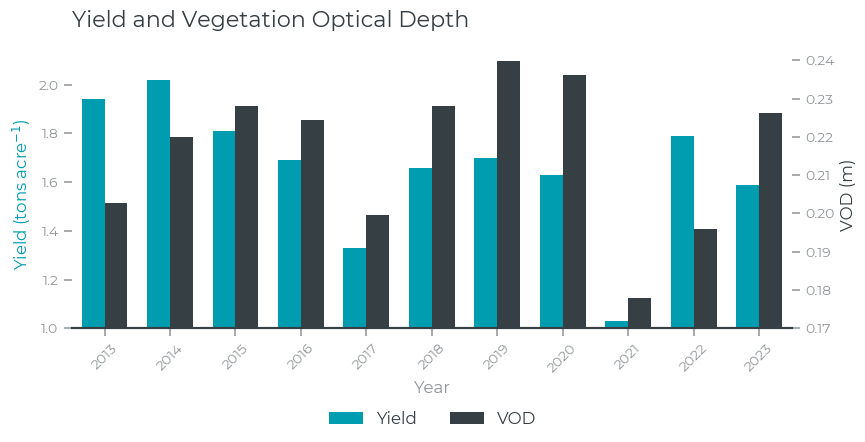

In [5]:
VOD_daily = pd.read_csv(f"csv/VOD_C_ND.csv",skiprows=6,index_col='date',parse_dates=True).rename(columns={'VOD-AMSR2-C1-DESC_V5.0_1000':"VOD"})
VOD_daily = VOD_daily[(VOD_daily.index.month >= 5) & (VOD_daily.index.month < 8) & (VOD_daily.index.year>2012)]
VOD_growing_season = VOD_daily.groupby(VOD_daily.index.year).mean()
Yield_VOD = pd.concat([Yield, VOD_growing_season], axis=1, join="inner", )

fig, ax1 = plt.subplots(figsize=(8,4))
ax1.set_title("Yield and Vegetation Optical Depth")
Yield_VOD.plot.bar(y='Yield',ax=ax1,width=0.35,rot=45,position=1,legend=False)
ax1.set_xlabel('Year')
ax1.set_ylabel('Yield (tons acre$^{-1}$)',color='C0')
ax1.set_ylim([1.0,2.1])
ax2 = ax1.twinx()
Yield_VOD.plot.bar(y='VOD',ax=ax2,width=0.35,rot=45,position=0,color='C1',legend=False)
ax2.set_ylabel('VOD (m)',color='C1')
ax2.set_xlim(np.where(Yield_SWC.index == 2013)[0] - 0.5, np.where(Yield_SWC.index == 2023)[0] + 0.5)
ax2.set_ylim([0.17,0.24])
fig.legend(loc="lower center",ncols=2)
fig.subplots_adjust(left=0.05, bottom=0.28, right=0.95, top=0.95, wspace=0.4, hspace=0.2)

Like SWC and LST, VOD also gives a good fit with yield!



## Statistics

We now have three variables that show a very similar pattern as the yield: SWC, LST and VOD. Can we say something about which indicator is the best predictor of yield? We can quantify the performance of each predictor by computing correlation coefficients: bluntly said: the higher the correlation between two time series, the higher the similarity between both. Two widely-used correlation coefficients are Spearman $R$ and Pearson $R$. 

Pearson $R$ measures the extent of which deviations from the mean in one time series match with deviations from the mean from the other. Spearman $R$ measures the extent of which the rank of the values (from low to high) matches between both. 

Both coefficients have a value between -1 and 1. A value of 1 means perfect correlation, and -1 perfect anticorrelation. A value of zero means no correlation (the values are unrelated).

In [6]:
merged_table = pd.concat([Yield, SWC_growing_season, LST_growing_season, VOD_growing_season], axis=1, join="inner")

corr_d = {'Pearson R':   [pearsonr(merged_table["Yield"],merged_table['SWC']).statistic,
                          pearsonr(merged_table["Yield"],merged_table['LST']).statistic,
                          pearsonr(merged_table["Yield"],merged_table['VOD']).statistic], 
          'Spearman R': [spearmanr(merged_table["Yield"],merged_table['SWC']).statistic,
                         spearmanr(merged_table["Yield"],merged_table['LST']).statistic,
                         spearmanr(merged_table["Yield"],merged_table['VOD']).statistic]}
corr_table = pd.DataFrame(data = corr_d, index = ['SWC', 'LST', 'VOD'])
corr_table

,Pearson R,Spearman R
SWC,0.853,0.800
LST,-0.819,-0.864
VOD,0.490,0.155


As expected from the plots, the correlation coefficients are high, especially for LST and SWC. Note the minus sign for LST, which indicates the anti-correlation: low LST values correspond to high yields. VOD has a lower correlation, especially when looking at Spearman $R$, although still positive.

An important question we also need to answer is the correlation between the predictors themselves: are for example LST and SWC independent of each other, or are they closely tied? We can compute the correlation coefficients between VOD, LST, and SWC to answer this. Below we compute the correlation coefficients and make a plot. 

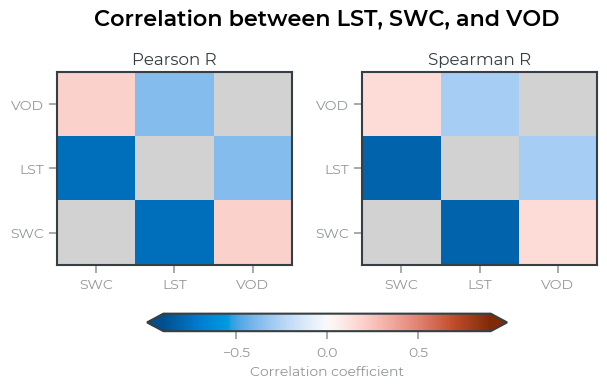

In [7]:
spearman_r_array = spearmanr(merged_table).statistic[1:,1:] 
pearson_r_array = np.corrcoef(merged_table.T)[1:,1:]

fig, axs = plt.subplots(1,2,figsize=(6,3.5))
fig.suptitle("Correlation between LST, SWC, and VOD", fontsize=16)
pcm = axs[0].pcolormesh(np.ma.masked_array(pearson_r_array, np.abs(pearson_r_array) > .9), cmap=cmap_RdBu,vmin=-0.9, vmax=0.9)
axs[1].pcolormesh(np.ma.masked_array(spearman_r_array, np.abs(spearman_r_array) > .9),cmap=cmap_RdBu,vmin=-0.9, vmax=0.9)
axs[0].set_title('Pearson R',fontsize=12, loc='center', pad=6)
axs[1].set_title('Spearman R',fontsize=12, loc='center', pad=6)
for ax in axs:
    ax.set_xticks((0.5,1.5,2.5))
    ax.set_yticks((0.5,1.5,2.5))
    ax.set_xticklabels(['SWC','LST','VOD'])
    ax.set_yticklabels(['SWC','LST','VOD'])
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.spines["left"].set_visible(True)    

fig.subplots_adjust(right=0.95, bottom=0.25,left=0.05,top=0.8, wspace=0.3)
cbar_ax = fig.add_axes([0.2, 0.06, 0.6, 0.05])
cbar = fig.colorbar(pcm, cax=cbar_ax,orientation='horizontal',extend='both')
cbar.ax.tick_params(labelsize=10,pad=5)
cbar.set_label(label='Correlation coefficient',size=10)

Soil water content and Land Surface Temperature are highly anti-correlated. From a physical point this makes sense: when the soil is dry, the energy from incoming solar radiation cannot be used to evaporate the water in the soil (i.e. latent heat), and thus more energy is used to heat the surface (sensible heat). Conversely, when it's hotter, more water will evaporate and thus the soil becomes drier. The strong anti-correlation implies that there is little additional information in LST observations that is not in the SWC observations. This becomes important when we want to predict yield from a combination of SWC and LST: the added value of two variables over one is probably going to be small. 

The correlation between VOD and SWC/LST is much smaller. This means that changes in VOD often differ from changes in LST/SWC and therefore, VOD might add additional predictive information on yield on top of SWC and LST.

## Forecasting yield using SWC, LST, and VOD
We have now learned that SWC, LST, and VOD correlate with the yield. Now we want to know whether we can make a more accurate yield prediction using a combination of these three Planetary Variables. Here, we are going to use a simple regression model to find out. We want to solve the following model:

$$
Y(t) - \overline{Y} = x_0 + x_1\left(S(t) - \overline{S}\right) + x_2\left(T(t) - \overline{T}\right) + x_3\left(V(t) - \overline{V}\right) + \epsilon
$$

Here $Y(t)$ is the annual yield in year $t$, and $S(t)$, $T(t)$, and $V(t)$ are SWC, LST, and VOD over the growing season in year $t$. A horizontal bar over a variable (e.g. $\overline{V}$) refers to the *climatology*: the long-term average value of this quantity, computed over many years. Here, we are interested in the *anomalies*: the deviation of the yield from its long-term average. We will use the prime ($'$) symbol to refer to the anomalies: $V'(t) = V(t) - \overline{V}$.

In our regression model, we are going to look for the values of $[x_0 \cdots x_3]$ that gives the smallest value of the error $\epsilon$ squared ($\epsilon^2$). We refer to this solution as the least-squares solution. 

In matrix form, we are going to minimize $\epsilon^2$ in this equation:
$$
\begin{bmatrix}
1 & S'(0) & T'(0) & V'(0) \\
\vdots  & \vdots & \vdots  & \vdots \\
1 & S'(n) & T'(n) & V'(n) \\
\end{bmatrix}

\begin{bmatrix}
x_0 \\
x_1 \\
x_2 \\
x_3 \\
\end{bmatrix}

= 
\begin{bmatrix}
Y(0) \\
\vdots \\
Y(n) \\
\end{bmatrix}
+ \epsilon
$$

where we use data from 0 to $n$. There exists a unique solution for this problem. There are a lot of text books on multiple regression, and Wikipedia has a good [summary](https://en.wikipedia.org/wiki/Linear_least_squares). Here, we use numpy's `lscov` function to find the solution for us.   

The first step is finding the climatologies and computing the anomalies.

In [8]:
merged_mean = merged_table.mean()
merged_anomalies = merged_table - merged_mean

We have now computed the means:

In [9]:
merged_mean

Yield     1.654
SWC       0.229
LST     284.531
VOD       0.216
dtype: float64

and the anomalies:

In [10]:
merged_anomalies

,Yield,SWC,LST,VOD
2013,0.286,0.025,-0.903,-0.014
2014,0.366,0.032,-1.660,0.004
2015,0.156,0.002,-0.614,0.012
2016,0.036,-0.019,0.183,0.008
2017,-0.324,-0.032,0.263,-0.017
2018,0.006,-0.011,1.129,0.012
2019,0.046,0.006,-1.149,0.023
2020,-0.024,0.005,0.036,0.020
2021,-0.624,-0.034,2.024,-0.038
2022,0.136,0.032,-0.290,-0.020


Now we can solve the model and show the resulting yield forecast

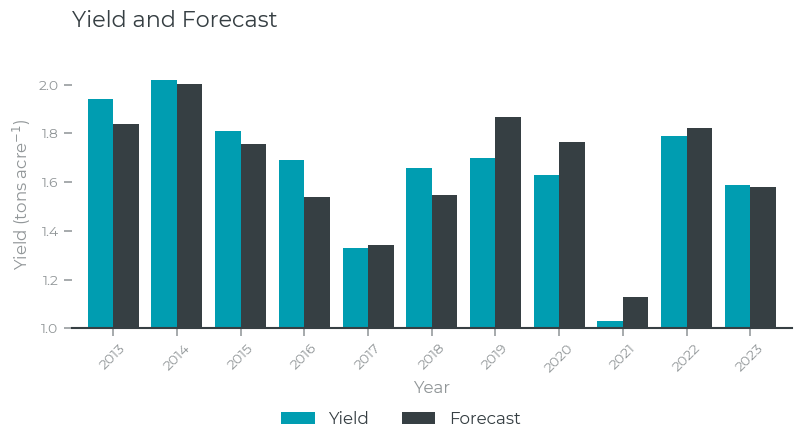

In [11]:
design_matrix = np.vstack((np.ones(len(merged_anomalies)),merged_anomalies['SWC'], merged_anomalies['LST'],merged_anomalies['VOD'])).T
solution = np.linalg.lstsq(design_matrix,merged_anomalies['Yield'])[0]
if "Forecast" not in merged_table:
    merged_table.insert(4, "Forecast", merged_mean['Yield']+design_matrix@solution)

fig, ax = plt.subplots(figsize=(8,4))
ax.set_title("Yield and Forecast")
merged_table.plot.bar(y=['Yield','Forecast'], ax=ax, width=0.8, rot=45, legend=False)
ax.set_xlabel('Year')
ax.set_ylabel('Yield (tons acre$^{-1}$)')
ax.set_ylim([1.0,2.1])
fig.legend(loc="lower center",ncols=2)
fig.subplots_adjust(left=0.05, bottom=0.28, right=0.95, top=0.95, wspace=0.4, hspace=0.2)

That looks like a good fit! What are the correlation coeffcients between the forecasted and actual yield?

In [12]:
corr_table = pd.DataFrame(data = {'Correlation coefficient':[pearsonr(merged_anomalies['Yield'], design_matrix@solution).statistic, spearmanr(merged_anomalies['Yield'], design_matrix@solution).statistic]}, index = ['Pearson R', 'Spearman R'])
corr_table

,Correlation coefficient
Pearson R,0.928
Spearman R,0.809


The Pearson correlation coefficient of our model is above the values we got when using a single variable. Spearman R is slightly lower than when only using LST. Keep in mind here that the method that we have chosen (Linear least squares) effectively looks for the solution $[x_0 \cdots x_3]$ that provides the highest Pearson correlation coefficient. Other methods, including machine learning techniques, might find a set of coefficients that lead to a higher Spearman R. 

But how does our solution look like? Let's see:

In [13]:
pd.DataFrame(data = {"value":solution}, index = ['x0','x1','x2','x3'])

,value
x0,-0.000
x1,7.214
x2,-0.064
x3,3.959


What does this mean? The first parameter ($x_0$), which is the mean value, is essentially zero. That's expected, because we use anomalies throughout, and the mean of the anomalies is zero by definition. The second parameter ($x_1$) sets the yield anomaly due to SWC anomalies. It's positive, which means that a dry soil leads to lower yields. $x_2$ represents the change in yield due to LST changes. It's value is negative: we see lower yields in hotter years. The link with VOD ($x_3$) is again positive. Since VOD is a proxy for the amount of wet vegetation, this is fully expected: when there's more vegetation on the fields, we expect higher yields.  

Now we have the values for $[x_0 \cdots x_3]$, we can fill them in into our equation, and we have a model to make predictions:
$$
Y_\textrm{predicted}(t) = \overline{Y} -0.000 + 7.214 S'(t) -0.064 T'(t) + 3.959 V'(t)
$$

We already have the values of SWC, LST, and VOD for 2024, but the USDA data is not yet available. Let's make an educated guess of the hay yield for 2024 in North Dakota!

First, get the 2024 values for LST, SWC, and VOD, and subtract the climatology:


In [14]:
SWC_anom_2024 = SWC_growing_season.loc[2024]["SWC"] - merged_mean['SWC']
LST_anom_2024 = LST_growing_season.loc[2024]["LST"] - merged_mean['LST']
VOD_anom_2024 = VOD_growing_season.loc[2024]["VOD"] - merged_mean['VOD']

We can fill in these anomalies into the equation above to get our 2024 yield forecast:

In [15]:
Yield_forecast_2024 = (merged_mean['Yield'] + solution[0] 
                                            + solution[1] * SWC_anom_2024 
                                            + solution[2] * LST_anom_2024 
                                            + solution[3] * VOD_anom_2024 
                      )
print("Yield forecast for 2024: %.3f tons acre-1" % Yield_forecast_2024)

Yield forecast for 2024: 1.756 tons acre-1


We have a forecast! Finally, let's plot the time series including the forecast:

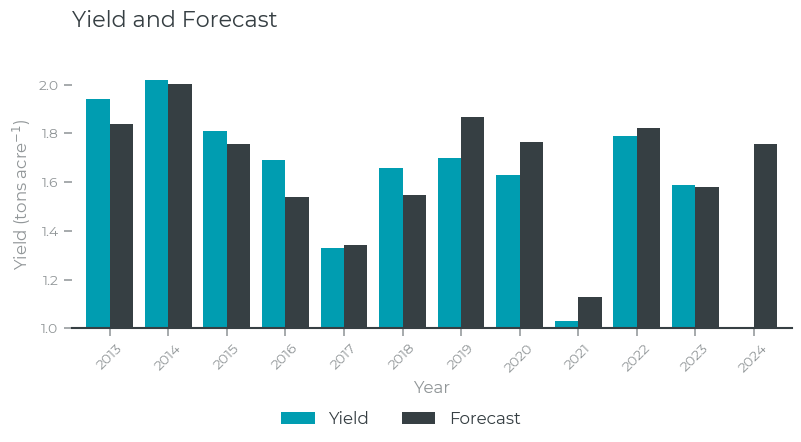

In [16]:
fcst = pd.concat((merged_table,pd.DataFrame(index = [2024],data={"Forecast":Yield_forecast_2024})))
fig, ax = plt.subplots(figsize=(8,4))
ax.set_title("Yield and Forecast")
fcst.plot.bar(y=['Yield','Forecast'], ax=ax, width=0.8, rot=45, legend=False)
ax.set_xlabel('Year')
ax.set_ylabel('Yield (tons acre$^{-1}$)')
ax.set_ylim([1.0,2.1])
fig.legend(loc="lower center",ncols=2)
fig.subplots_adjust(left=0.05, bottom=0.28, right=0.95, top=0.95, wspace=0.4, hspace=0.2)



It looks like 2024 is going to be a good yield year for hay in North Dakota. Now we wait for the USDA numbers for 2024 to see whether we have done a good job. One warning here: this is a pretty simple and not well-validated forecast, so take it with a pinch of salt!

## Conclusions
We have made a forecast of the hay yield in North Dakota for the year 2024 using a simple regression with three Planetary Variables (SWC, LST, and VOD). While this analysis is rather simple and lacks the rigorous testing needed to assess the reliability of the regression, it does show that Planetary Variables are a good indicator of crop growth: all three PV's show a clear correlation with the annual yield. 

## References

### Data sources
- [USDA yield data](https://www.nass.usda.gov/Data_and_Statistics/)
- [EO browser](https://apps.sentinel-hub.com/eo-browser/)

### Planetary Variables
- SWC retrieval algorithm: 
  - [Owe et al. (2008)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2007JF000769)
  -  [Van der Schalie et al. (2017)](https://www.sciencedirect.com/science/article/abs/pii/S0034425715001029)
- SWC validation: 
  - [Planet SWC Whitepaper](https://planet.widen.net/s/drrxtldpwg)
- LST validation:
  - [Planet LST Whitepaper](https://planet.widen.net/s/j9rl92dgpq) 
- VOD explanation and use cases: 
  - [Zotta et al. (2024)](https://essd.copernicus.org/articles/16/4573/2024/essd-16-4573-2024.html)

### Planet
- [Planet](HTTPS://www.planet.com)
- [Documentation center](https://developers.planet.com/docs/planetary-variables/)

### Contact us!
- [Contact Sales](https://www.planet.com/contact-sales/)
